In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import seaborn as sns
from scipy import stats
from scipy.stats import norm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


**Data Exploration**

In [2]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test=pd.read_csv("/kaggle/input/titanic/test.csv")
# print(train.head())
print ('The train data has {0} rows and {1} columns'.format(train.shape[0],train.shape[1]))
print ('----------------------------')
print ('The test data has {0} rows and {1} columns'.format(test.shape[0],test.shape[1]))

The train data has 891 rows and 12 columns
----------------------------
The test data has 418 rows and 11 columns


In [3]:
train.columns[train.isnull().any()]

Index(['Age', 'Cabin', 'Embarked'], dtype='object')

In [4]:
miss = train.isnull().sum()/len(train)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

Embarked    0.002245
Age         0.198653
Cabin       0.771044
dtype: float64

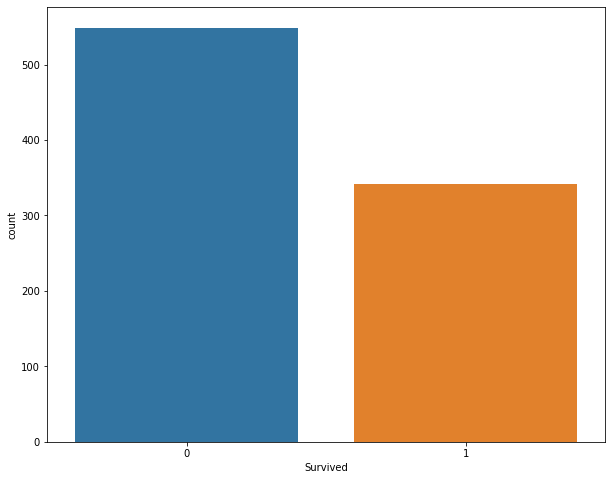

In [5]:
sns.countplot(train["Survived"])

In [6]:
#separate variables into new data frames
numeric_data = train.select_dtypes(include=[np.number])
cat_data = train.select_dtypes(exclude=[np.number])
print ("There are {} numeric and {} categorical columns in train data".format(numeric_data.shape[1],cat_data.shape[1]))

There are 7 numeric and 5 categorical columns in train data


             PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005007 -0.035144  0.036847 -0.057527 -0.001652   
Survived       -0.005007  1.000000 -0.338481 -0.077221 -0.035322  0.081629   
Pclass         -0.035144 -0.338481  1.000000 -0.369226  0.083081  0.018443   
Age             0.036847 -0.077221 -0.369226  1.000000 -0.308247 -0.189119   
SibSp          -0.057527 -0.035322  0.083081 -0.308247  1.000000  0.414838   
Parch          -0.001652  0.081629  0.018443 -0.189119  0.414838  1.000000   
Fare            0.012658  0.257307 -0.549500  0.096067  0.159651  0.216225   

                 Fare  
PassengerId  0.012658  
Survived     0.257307  
Pclass      -0.549500  
Age          0.096067  
SibSp        0.159651  
Parch        0.216225  
Fare         1.000000  


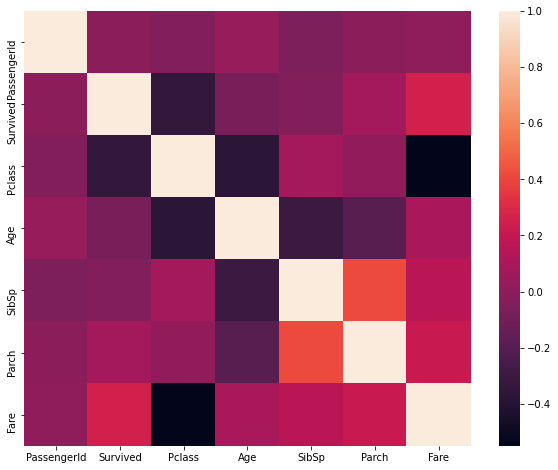

In [7]:
corr = numeric_data.corr()
print(corr)
sns.heatmap(corr)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3348: RuntimeWarning: divide by zero encountered in double_scalars
  msw = sswn / dfwn
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3339: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / len(a)


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

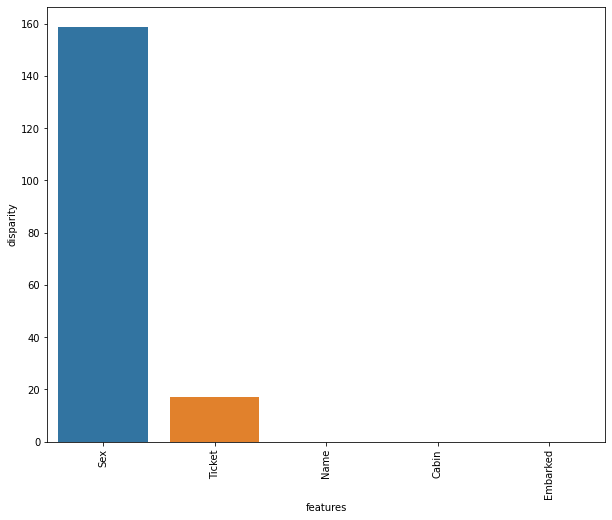

In [8]:
cat = [f for f in train.columns if train.dtypes[f] == 'object']
def anova(frame):
    anv = pd.DataFrame()
    anv['features'] = cat
    pvals = []
    for c in cat:
           samples = []
           for cls in frame[c].unique():
                  s = frame[frame[c] == cls]['Survived'].values
                  samples.append(s)
           pval = stats.f_oneway(*samples)[1]
           pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

cat_data['Survived'] = train.Survived.values
k = anova(cat_data) 
k['disparity'] = np.log(1./k['pval'].values) 
sns.barplot(data=k, x = 'features', y='disparity') 
plt.xticks(rotation=90) 
plt 

**Data Preprocessing  and Feature Engineering**

In [11]:
alldata = train.append(test)
alldata['Age'].fillna(alldata['Age'].mean(), inplace=True)
for c in alldata.drop(['Survived'], axis=1).columns:
    alldata[c].fillna(0, inplace=True)


In [12]:
     alldata["Cabin"] = (alldata["Cabin"] != 0) * 1
if 'Name' in alldata.columns:
    alldata["Name_len"] = alldata["Name"].str.len()
    alldata["Name_brackets"] = alldata["Name"].apply(lambda x: ('(' in x) * 1)
    alldata=alldata.drop(['Name'], axis=1)
if 'PassengerId' in alldata.columns:
    alldata=alldata.drop(['PassengerId'], axis=1)
if 'Embarked_0' not in alldata.columns:
    alldata=pd.concat([alldata, pd.get_dummies(alldata.Embarked, prefix='Embarked')], axis=1, join='inner')
if 'Embarked' in alldata.columns:
    alldata=alldata.drop(['Embarked'], axis=1)
    
if 'Pclass_1' not in alldata.columns:
    alldata=pd.concat([alldata, pd.get_dummies(alldata.Pclass, prefix='Pclass')], axis=1, join='inner')
    
alldata["Child"] = alldata["Age"].apply(lambda x: (x<13) * 1)
alldata["Aged"] = alldata["Age"].apply(lambda x: (x>60) * 1)
if 'Ticket' in alldata.columns:
    alldata['Ticket_char'] = alldata['Ticket'].apply(lambda x: (ord(x[0])>57) * 1) 
    alldata=alldata.drop(['Ticket'], axis=1)
alldata['Sex'] = alldata['Sex'].apply(lambda x: (x=='female') * 1)
alldata=alldata.drop(['Pclass_2'], axis=1)
alldata['Parch_sex']=alldata['Parch']*alldata['Sex']
alldata

,Age,Cabin,Fare,Parch,Pclass,Sex,SibSp,Survived,Name_len,Name_brackets,Embarked_0,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_3,Child,Aged,Ticket_char,Parch_sex
0,22.000000,0,7.2500,0,3,0,1,0.0,23,0,0,0,0,1,0,1,0,0,1,0
1,38.000000,1,71.2833,0,1,1,1,1.0,51,1,0,1,0,0,1,0,0,0,1,0
2,26.000000,0,7.9250,0,3,1,0,1.0,22,0,0,0,0,1,0,1,0,0,1,0
3,35.000000,1,53.1000,0,1,1,1,1.0,44,1,0,0,0,1,1,0,0,0,0,0
4,35.000000,0,8.0500,0,3,0,0,0.0,24,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,29.881138,0,8.0500,0,3,0,0,NaN,18,0,0,0,0,1,0,1,0,0,1,0
414,39.000000,1,108.9000,0,1,1,0,NaN,28,0,0,1,0,0,1,0,0,0,1,0
415,38.500000,0,7.2500,0,3,0,0,NaN,28,0,0,0,0,1,0,1,0,0,1,0
416,29.881138,0,8.0500,0,3,0,0,NaN,19,0,0,0,0,1,0,1,0,0,0,0


In [13]:
train_new = alldata[alldata['Survived'].notnull()]
test_new = alldata[alldata['Survived'].isnull()]

print (train_new.shape)
print ('----------------')
print (test_new.shape)



(891, 20)
----------------
(418, 20)


                    Age     Cabin      Fare     Parch    Pclass       Sex  \
Age            1.000000  0.232314  0.091002 -0.179882 -0.330367 -0.084461   
Cabin          0.232314  1.000000  0.482075  0.036987 -0.725541  0.140391   
Fare           0.091002  0.482075  1.000000  0.216225 -0.549500  0.182333   
Parch         -0.179882  0.036987  0.216225  1.000000  0.018443  0.245489   
Pclass        -0.330367 -0.725541 -0.549500  0.018443  1.000000 -0.131900   
Sex           -0.084461  0.140391  0.182333  0.245489 -0.131900  1.000000   
SibSp         -0.232515 -0.040460  0.159651  0.414838  0.083081  0.114631   
Survived      -0.070323  0.316912  0.257307  0.081629 -0.338481  0.543351   
Name_len       0.030651  0.190943  0.155832  0.252282 -0.220001  0.448759   
Name_brackets  0.160374  0.140154  0.090407  0.206592 -0.165159  0.503102   
Embarked_0     0.073966  0.087042  0.045646 -0.022467 -0.074282  0.064296   
Embarked_C     0.032210  0.208528  0.269335 -0.011069 -0.243292  0.082853   

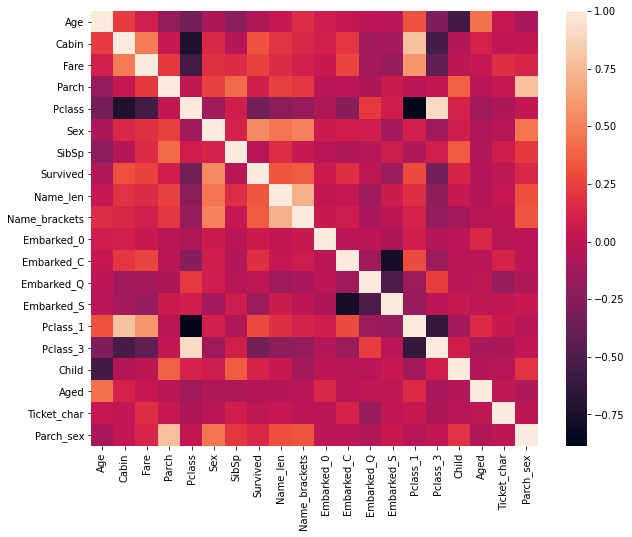

In [14]:
corr = train_new.corr()
print(corr)
sns.heatmap(corr)

In [15]:
del test_new['Survived']
del train_new['Embarked_0']
del test_new['Embarked_0']
Y_train=train_new['Survived']
del train_new['Survived']


Normalization

In [16]:
mean=train_new.mean()
std=train_new.std()

In [17]:

train_norm=(train_new-mean)/std
test_norm=(test_new-mean)/std

In [18]:
train_norm['Survived']=Y_train

In [19]:
msk = np.random.rand(len(train_norm)) < 0.75
train_set = train_norm
validation = train_norm[~msk]

y_train_set=train_set['Survived']
x_train_set=train_set.drop(['Survived'], axis=1)
# x_val=validation.drop(['Survived'], axis=1)
# y_val=validation['Survived']

# msk2 = np.random.rand(len(train_norm)) < 0.75
# train_set2 = train_norm[msk2]
# validation2 = train_norm[~msk2]

# y_train_set2=train_set2['Survived']
# x_train_set2=train_set2.drop(['Survived'], axis=1)
# x_val2=validation2.drop(['Survived'], axis=1)
# y_val2=validation2['Survived']

**Model Training**

Support Vector Machine

In [20]:
from sklearn.svm import SVC
from sklearn import metrics
svc=SVC(C=0.7) 
svc.fit(x_train_set,y_train_set)

# y_predSVC=svc.predict(x_val)
# print(metrics.accuracy_score(y_val,y_predSVC))

y_pSVC=svc.predict(test_norm)

# svc2=SVC(C=0.7) 
# svc2.fit(x_train_set2,y_train_set2)

# y_predSVC2=svc2.predict(x_val2)
# print(metrics.accuracy_score(y_val2,y_predSVC2))

XGBoost Classifier

In [21]:
import xgboost as xgb
from xgboost import XGBClassifier

xg = XGBClassifier()
xg.fit(x_train_set, y_train_set)

# y_predXGB=xg.predict(x_val)
# print(metrics.accuracy_score(y_val,y_predXGB))
y_pXGB=xg.predict(test_norm)

# xg2 = XGBClassifier()
# xg2.fit(x_train_set2, y_train_set2)

# y_predXGB2=xg2.predict(x_val2)
# print(metrics.accuracy_score(y_val2,y_predXGB2))

Gaussian Naive Bayes Classifier

In [22]:
# from sklearn.naive_bayes import GaussianNB
# gnb = GaussianNB()
# gnb.fit(x_train_set, y_train_set)

# y_predNB=gnb.predict(x_val)
# print(metrics.accuracy_score(y_val,y_predNB))

# gnb2 = GaussianNB()
# gnb2.fit(x_train_set2, y_train_set2)

# y_predNB2=gnb2.predict(x_val2)
# print(metrics.accuracy_score(y_val2,y_predNB2))

Neural Network

In [23]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

model = Sequential()
model.add(Dense(30, activation='relu', input_dim=x_train_set.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])         

model.fit(x_train_set, y_train_set, epochs=10, batch_size=32,verbose=0)
# y_predNN=model.predict_classes(x_val)
y_pNN=model.predict_classes(test_norm)

# print(metrics.accuracy_score(y_val,y_predNN))

# model.fit(x_train_set2, y_train_set2, epochs=10, batch_size=32,verbose=0)
# y_predNN2=model.predict_classes(x_val2)
# print(metrics.accuracy_score(y_val2,y_predNN2))

Using TensorFlow backend.


Ensemble Model

In [26]:
# y_predA=((y_predSVC+y_predXGB+y_predNN.reshape(y_predNN.shape[0],))>1.5)*1
# print(metrics.accuracy_score(y_val,y_predA))

y_predA=((y_pSVC+y_pXGB+y_pNN.reshape(y_pNN.shape[0],))>1.5)*1

# y_predA2=((y_predSVC2+y_predXGB2+y_predNN2.reshape(y_predNN2.shape[0],))>1.5)*1
# print(metrics.accuracy_score(y_val2,y_predA2))

Save results

In [25]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': y_predA})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
